# implementation
[alg. lepesek](https://discourse.processing.org/t/wave-collapse-function-algorithm-in-processing/12983)


[interaktiv alg](https://oskarstalberg.com/game/wave/wave.html)

In [1]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from random import choices
%matplotlib inline
%config InlineBackend.figure_format ='svg'
from PIL import Image
import requests
from tqdm import trange
from IPython import display

In [42]:
class WFC:
    def __init__(self, imPath, imDims = None, out_dims = (80, 100)):
        self._imPath = imPath
        self._imDims = imDims
        self._load_im_to_bitmap()
        
        self._preprocess_bitmap()
            
        self.out_dims = out_dims
        
        #create "wave" vec
        self.W = np.ones((*out_dims, len(self.tile_counts)), dtype = "bool") 
        
        #create entropy vec
        self.H = np.ones((out_dims), dtype = "float")
        self.H[:,:] = len(self.tile_counts)
        
        self.output_image = np.zeros((*out_dims, 3), dtype = "uint8")
        
        self.failed = np.zeros_like(self.output_image)
        
        
    def _load_im_to_bitmap(self):
        """
        Load input image to numpy array.
        
        If imDims (height, width) is set, then resize image
        to the correct resolution (one pixel <=> one color)
        """
        with Image.open(self._imPath) as im:
            if self._imDims: # resize to correct resolutiom
                bitmap = np.asarray(im.resize(self._imDims, 
                                    resample = Image.Resampling.NEAREST))
            else:
                bitmap = np.asarray(im)
                
        self.bitmap = bitmap
        
        
        
    def _preprocess_bitmap(self):
        """
        Scan (3,3) tiles in the input bitmap, 
        and compute adjecancy rules.
        """
        
        # scan (3,3,3) patterns in input bitmap 
        
        aa = np.hstack([self.bitmap,self.bitmap])
        aaaa = np.vstack([aa,aa]) #edge overflow
        self.tiles = []

        for x in range(self.bitmap.shape[0]):
            for y in range(self.bitmap.shape[1]): # window upper left at (x,y)
                tile = aaaa[x:x+3,y:y+3,:]
                self.tiles.append(tile)

        
        self.tile_hashes = [hash(t.data.tobytes()) for t in self.tiles]  
        self.tile_counts = Counter(self.tile_hashes)
        self.get_tile_from_hash = {h : t for h, t in zip(self.tile_hashes, self.tiles)}
        self.nr_tiles = len(self.tile_counts)

        # A : (melyik csempe, melyik szomszeddal, melyik iranyban) = szomszedos-e?
        self.A = np.zeros((self.nr_tiles,self.nr_tiles,4), dtype = "bool")

        for t_idx, t_id in enumerate(self.tile_counts):
            for nb_idx, nb_id in enumerate(self.tile_counts):
                a = self.get_tile_from_hash[t_id]
                b = self.get_tile_from_hash[nb_id]
                
                # 0. irany : nyugat, bal 
                if np.all(a[:,:2,:] == b[:,1:,:]): #ha atfedesben van
                    self.A[t_idx, nb_idx, 0] = True

                # 1. irany : kelet, jobb 
                if np.all(a[:,1:,:] == b[:,:2,:]): 
                    self.A[t_idx, nb_idx, 1] = True

                # 2. irany : eszak, fel 
                if np.all(a[:2,:,:] == b[1:,:,:]): 
                    self.A[t_idx, nb_idx, 2] = True

                # 3. irany : del, le 
                if np.all(a[1:,:,:] == b[:2,:,:]): 
                    self.A[t_idx, nb_idx, 3] = True
                    
                    
        #tile hash to indices dict
        self.id_to_idx = { id : n  for n, id in enumerate(self.tile_counts.keys()) }

                    
    def _observation(self):
        H, W = self.H, self.W
        """
        1.find min entropy
        2.choose from possible tiles, according to input deviation

        returns (which index, what color)
        """
        #find min entropy
        i,j = np.unravel_index(H.argmin(), H.shape) # find argmin indices

        #choose from possible tiles, according to input deviation
        population = []
        weights = []
        for b, t_id in zip(W[i,j], self.id_to_idx):
            if b: # ha ez meg megengedett csempe
                population.append(t_id)
                weights.append(self.tile_counts[t_id])


        return (i,j), choices(population, weights=weights)[0]

    
    
    def _collapse(self):
        """
        1. get min entropy tile
        2. update W an H
        3. color output_image

        return the collapsed index (i,j)
        """
        
        #get min entropy tile 
        (i,j), t_id = self._observation() 

        #update W at this tile
        self.W[i,j, :] = False
        self.W[i,j, self.id_to_idx[t_id]] = True

        # set entropy to inf for the collapsed cell
        self.H[i,j] = float("inf")

        # color the (i,j) pixel in the output_image
        # with the left upper color of the coosen tile.
        self.output_image[i,j, :] = self.get_tile_from_hash[t_id][0,0,:] #

        return (i,j)
    
    
    def _propagation(self, i,j):
        """
        start updating W from (i,j) using Adjacency_rules
        """

        stack = {(i,j)} #start from last recent collapsed cell
        while stack:
            idx_current = stack.pop() # a kozepso, akinek a szomszedait vizsgaljuk

            w,h = self.W.shape[1], self.W.shape[0]
            i,j = idx_current

            nbr_idxs = [(i, (j-1) % w), # 0. irany : nyugat, bal 
                        (i, (j+1) % w), # 1. irany : kelet, jobb
                        ((i-1) % h, j), # 2. irany : eszak, fel
                        ((i+1) % h, j)  # 3. irany : del, le
                        ]

            for dir, idx_nb in enumerate(nbr_idxs):

                if self.H[idx_nb] != float("inf"): #csak ha meg nem collapsed a nb
                    possible_tiles_at_current = self.W[idx_current]

                    possible_nbrs_at_dir = np.any(self.A[possible_tiles_at_current, :, dir],
                                                    axis = 0)
                    x,y = idx_nb
                    available = self.W[x,y, :]

                    # check if the neighbour is need to be updated at all
                    # available is not subset of possible_nbrs_at_dir ?
                    if not ( np.all( possible_nbrs_at_dir[available] )):

                        intersection = possible_nbrs_at_dir & available

                        if np.sum(intersection) == 0:
                            self.failed[x,y, :] = (0, 255, 0)
                            # return
                        else:
                            #update wave function at idx_nb
                            self.W[x,y, :] = intersection

                            # add nbr to stack
                            stack.add(idx_nb)
                            
                            
    def _update_entropy(self):
        """
        update H from the new W.
        """
        finished = self.H == float("inf")

        self.H[:,:] = np.sum(self.W, axis = 2) 
        self.H[:,:] += 0.1 * np.random.randn(*self.H.shape)

        self.H[finished] = float("inf")
        
    def run(self, gif_len = None):
        """
        Run the WFC algorithm.
        
        If `gif_len` is set, then create
        an animation from `gif_len` frames
        of the iteration.
        """
        frames = []
        
        pixels = self.out_dims[0] * self.out_dims[1]
        for t in trange(pixels):
            # run one step of the WFC 
            collapsed_idx = self._collapse()
            self._propagation(*collapsed_idx)
            self._update_entropy()
            
            # giff staff
            if gif_len and ((t % (pixels // gif_len) == 0) or (t ==  pixels - 1)):
                im = Image.fromarray(self.output_image)                
                imr = im.resize((self.out_dims[1]*10, self.out_dims[0]*10), Image.Resampling.NEAREST)
                frames.append(imr)
                    
        if gif_len:
            print(f"Making gif from {len(frames)} frames ... ", end = "")
            frames[0].save('images/gif_out.gif',
               save_all=True,
               append_images=frames[1:],
               optimize=True,
               duration=4, loop=0, dpi=(300, 300))
            
            print("Saved gif animation to " + 'images/gif_out.gif')
            
    def __repr__(self):
        """
        Pretty plot input bitmap, output image, and failed pixels.
        """
        
        fig, axs = plt.subplot_mosaic([['a', 'c'], ['b', 'c']],
                              layout='constrained', 
                              gridspec_kw={'width_ratios': [1, 3]},
                              figsize=(12, 6))

        axs['a'].imshow(self.bitmap)
        axs['a'].set_title('input bitmap')
        axs['b'].imshow(self.failed)
        axs['b'].set_title(f'failed pixels (sum: {np.sum(self.failed != 0)})')
        axs['c'].imshow(self.output_image)
        axs['c'].set_title('wfc result')

        plt.show()
        return ""
            

# examples

## flower

100%|██████████████████████████████████████| 8000/8000 [00:22<00:00, 358.12it/s]


Making gif from 51 frames ... Saved gif animation to images/gif_out.gif


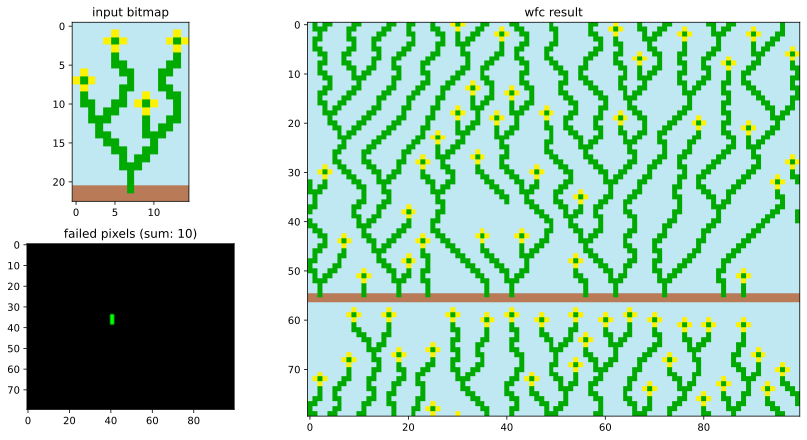

In [35]:
w = WFC("images/flowers.png", imDims = (15,23))
w.run(gif_len = 50)
w

In [36]:
display.Image(url='images/gif_out.gif', width = 500)  

## circle

In [39]:
w = WFC("images/circle.png")

100%|██████████████████████████████████████| 8000/8000 [00:43<00:00, 182.88it/s]


Making gif from 51 frames ... Saved gif animation to images/gif_out.gif


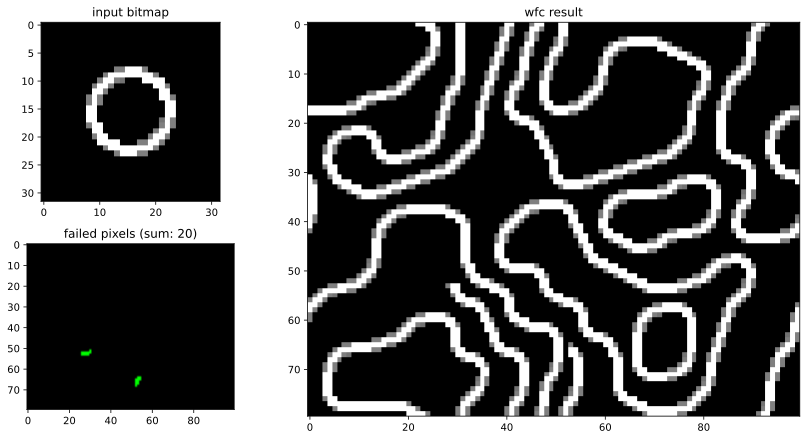

In [40]:
w.run(gif_len = 50)
w

In [41]:
display.Image(url='images/gif_out.gif', width = 500)  